# Final Project - Telecom 

The virtual telephony service CallMeMaybe is developing a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have a large number of missed incoming calls (internal and external) and a long waiting time for incoming calls. Moreover, if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness. Our goal is evaluate the least effective one and make a suggestion for improvement.

### Table of Contents

* [Data preprocessing](#chapter1)
    * [Users preprocessing](#section_1_1)
    * [Telecom preprocessing](#section_1_2)
* [EDA](#chapter2)
    * [Missing valuea](#section_2_1)
    * [Outliers](#section_2_2)
    * [Correlation](#section_2_3)
* [Identify ineffective operators](#chapter3)  
    * [Number of calls and duration](#section_3_1)
        * [Average duration call for an operator](#section_3_1_1)
    * [Missed calls](#section_3_2)
        * [Total missing calls for each operator](#section_3_2_1)
        * [The partial number of missed calls of total by each operator](#section_3_2_2)
    * [Waiting time](#section_3_3)
        * [Average time until answer](#section_3_3_1)
    * [Identify the most inafective operator](#section_3_4)
* [Hypothsis](#chapter4) 
    * [Prepering data for testing hypothsis](#section_4_1)
    * [Testing hypothesis ](#section_4_2)
* [Conclusion](#chapter5)
* [Presentation](#chapter6)
* [Dashbord](#chapter7)
* [Sources](#chapter8)

In [110]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Step 1 - open files and data preprocessing  <a class="anchor" id="chapter1"></a>

## users data preprocessing <a class="anchor" id="section_1_1"></a> 

In [2]:
users = pd.read_csv('telecom_clients_us.csv')
telecom = pd.read_csv('telecom_dataset_us.csv')

In [3]:
users.shape

(732, 3)

costomers: 732 users.

In [4]:
users.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [5]:
users.tail()

,user_id,tariff_plan,date_start
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22
731,166565,B,2019-08-08


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


* user_id could be changed to categorical type (not necessary) . 
* date_start will be changed to datetime type . 
* There are no missing values

In [7]:
users['date_start'] = pd.to_datetime(users['date_start']) 

In [8]:
users.describe(include='all')

,user_id,tariff_plan,date_start
count,732.000000,732,732
unique,NaN,3,73
top,NaN,C,2019-09-24 00:00:00
freq,NaN,395,24
first,NaN,NaN,2019-08-01 00:00:00
last,NaN,NaN,2019-10-31 00:00:00
mean,167431.927596,NaN,NaN
std,633.810383,NaN,NaN
min,166373.000000,NaN,NaN
25%,166900.750000,NaN,NaN


* The first users sighned up on 1.8.2019 and the last on 31.10.2019
* Unique values: There are 3 tariff plans: A,B,C

In [9]:
# checking for duplicates
users.duplicated().sum()

0

There are no duplicated values 

## telecom data preprocessing <a class="anchor" id="section_1_2"></a> 

In [10]:
telecom.shape

(53902, 9)

In [11]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


* Calls duration are in seconds
* We detected null values in the data (we will explore later)
* call duration = excluding waiting time
* total call duration = including waiting time

In [12]:
telecom.tail()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190
53901,168606,2019-11-19 00:00:00+03:00,in,False,NaN,True,2,0,64


In [13]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


* There are 8172 mising values in operaton_id column. Its 15% percent of the data. We testing the quality of the operators so we do need the information of each operator. We will look if there id a posability to fill the missing values. else, we will drop those values 
* We can change data types of dates and id for easier calculation and decrease the weight. 

In [14]:
# changing data types: 
telecom['user_id'] = telecom['user_id'].astype('category')
telecom['operator_id'] = telecom['operator_id'].astype('category')
telecom['date'] = pd.to_datetime(telecom['date'], format='%Y-%m-%d')
# the date type still looks odd so we will use date function
telecom['date'] = telecom['date'].dt.date
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


We changed data types and therefore reduce the weioght of the data .

In [15]:
telecom.describe(include='all')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
count,53902.0,53902,53902,53785,45730.0,53902,53902.000000,53902.000000,53902.000000
unique,307.0,119,2,2,1092.0,2,NaN,NaN,NaN
top,168187.0,2019-11-25,out,False,901884.0,False,NaN,NaN,NaN
freq,2580.0,1220,31917,47621,348.0,30334,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,16.451245,866.684427,1157.133297
std,NaN,NaN,NaN,NaN,NaN,NaN,62.917170,3731.791202,4403.468763
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,47.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,38.000000,210.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,572.000000,902.000000


* The dated of this data is from 2.8.2019 to 28.11.2019
* calls_count, call_duration, total_call_duration- There are outliers with very big numbers (max) . We will explore more on EDA part. 

In [16]:
telecom.duplicated().sum()

4900

In [17]:
telecom = telecom.drop_duplicates()

In [18]:
telecom.shape

(49002, 9)

There were 53902 rows. We dropped 4900 duplicated rows and left with 49002 rows .

#  Step 2 - EDA  <a class="anchor" id="chapter2"></a>

## missing values <a class="anchor" id="section_2_1"></a> 

In [19]:
# table with all missing valoues
telecom[telecom['operator_id'].isnull()].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
9,166377,2019-08-06,in,False,NaN,True,4,0,62
17,166377,2019-08-07,in,False,NaN,True,2,0,24
27,166377,2019-08-12,in,False,NaN,True,2,0,34


We will take several users to see if each of them has a unique value to fill the missing ones.

In [20]:
# user 1686026
telecom[telecom['user_id']==168606].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
53890,168606,2019-11-08,out,False,957922.0,True,2,0,40
53891,168606,2019-11-08,in,False,957922.0,True,1,0,7
53892,168606,2019-11-08,out,False,957922.0,False,2,255,328
53893,168606,2019-11-08,in,False,NaN,True,6,0,121
53894,168606,2019-11-08,in,False,957922.0,False,2,686,705


In [21]:
# user 168601
telecom[telecom['user_id']==168601].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
53805,168601,2019-11-01,in,False,NaN,True,1,0,2
53806,168601,2019-11-02,out,False,952914.0,True,5,0,118
53807,168601,2019-11-02,in,False,952914.0,False,5,449,473
53808,168601,2019-11-02,in,False,NaN,True,3,0,143
53809,168601,2019-11-02,out,False,952914.0,False,10,938,1079


In [22]:
# user 166377
telecom[telecom['user_id']==166377].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


No values were found that can be used to fill in missing data. There are several operators to each user and different information on each column. We will drop columns with missing values . 

In [23]:
telecom = telecom.dropna()
telecom.shape

(41491, 9)

We are left with 41491 rows. 

## Outliers <a class="anchor" id="section_2_2"></a> 

We will test outliers in the columns: calls_coiunt, call_duration, total_call_duration:

In [24]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29


Text(0, 0.5, 'count')

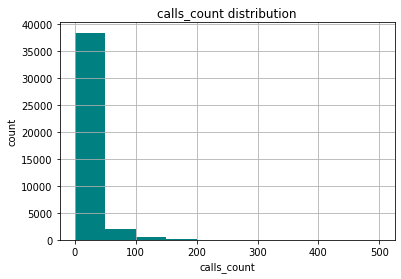

In [25]:
# calls_count column: 
telecom['calls_count'].hist(range=(0,500), color='teal')
plt.title('calls_count distribution')
plt.xlabel('calls_count')
plt.ylabel('count')

In [26]:
print(np.percentile(telecom['calls_count'],[95,97.5,99]))

[ 65.   94.  165.1]


In [27]:
telecom[telecom['calls_count']>165].sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
30185,167285,2019-10-23,out,False,908640.0,True,977,0,12731
6686,166582,2019-08-26,out,False,885876.0,False,318,44713,50817
6952,166582,2019-09-26,out,False,885876.0,True,720,0,19948
6645,166582,2019-08-21,out,False,885876.0,True,343,0,9104
43717,168018,2019-10-29,out,False,945900.0,False,229,2930,6058
7161,166582,2019-10-16,out,False,885890.0,False,629,49741,61791
40690,167827,2019-11-05,out,False,929428.0,True,1533,0,27889
7143,166582,2019-10-15,out,False,925922.0,True,634,0,18196
7276,166582,2019-10-29,out,False,885890.0,False,439,46835,55278
40565,167827,2019-10-17,out,False,929426.0,False,195,9613,13217


The 99 percentile is number of calls above 165 per day. Its a big number but we don't have enough information amd we can not decide whether the information is true. There may be a lot of employees who answer a lot of calls. We will leave this column as it is and continue to check the rest of the columns.

Text(0, 0.5, 'count')

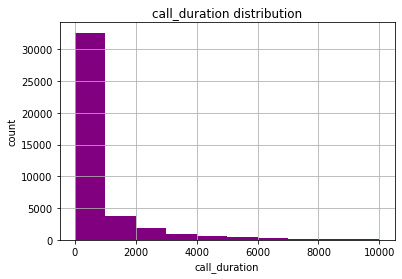

In [28]:
# call_duration column
telecom['call_duration'].hist(range=(0,10000), color='purple')
plt.title('call_duration distribution')
plt.xlabel('call_duration')
plt.ylabel('count')

In [29]:
print(np.percentile(telecom['call_duration'],[95,97.5,99]))

[ 4161.5   6619.25 10988.3 ]


In [30]:
telecom[telecom['call_duration']>10988].sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
52357,168361,2019-11-06,out,False,945302.0,False,84,11630,13270
52408,168361,2019-11-08,out,False,945280.0,False,70,15539,16827
6647,166582,2019-08-21,out,False,885890.0,False,511,66966,76310
7243,166582,2019-10-24,out,False,885890.0,False,530,48907,58352
52110,168361,2019-10-30,out,False,945312.0,False,93,15158,16946
7215,166582,2019-10-22,out,False,925922.0,False,815,32814,47708
6681,166582,2019-08-25,out,False,885890.0,False,125,15153,17507
50889,168252,2019-11-26,out,False,964666.0,False,95,13205,14989
52478,168361,2019-11-10,out,False,945304.0,False,75,11608,13019
6996,166582,2019-10-02,out,False,885890.0,False,445,27915,35964


* Here we see information about the 99th percentile. It seems that the call duration here above 3 hours and that is a lot. We again not have enough information on whether the time is reasonable or not. Although we would like to claim that this is not a reasonable time for one call because it is ineffective and hurts waiting calls.
* It is important to say that there are no clues to "blame" specific user or operator. We have diverse users and operators with long duration call .

Its important to check illogical information - duration above 24 hours:

In [31]:
telecom[telecom['call_duration']>86400].shape[0]

23

There are 23 illogical duration call. Because the entire 99th percentile is illogical, we'll drop all these rows.

In [32]:
telecom = telecom[telecom['call_duration']<86400]

Text(0, 0.5, 'count')

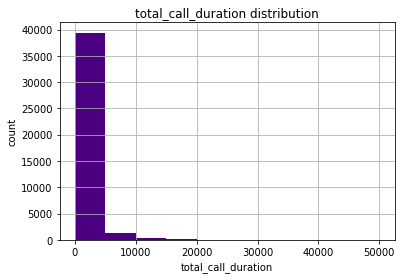

In [33]:
# total_call_duration column: 
telecom['total_call_duration'].hist(range=(0,50000), color='indigo')
plt.title('total_call_duration distribution')
plt.xlabel('total_call_duration')
plt.ylabel('count')

In [34]:
print(np.percentile(telecom['total_call_duration'],[95,97.5,99]))

[ 5010.65  8149.   13373.32]


Here we would rather look at the time it takes to answer a call:

In [35]:
#call wait
telecom['time_wait'] = telecom['total_call_duration'] - telecom['call_duration']

In [36]:
print(np.percentile(telecom['time_wait'],[95,97.5,99]))

[1229.   1886.   3343.65]


In [37]:
prcnt_99 = telecom[telecom['time_wait']>3495]

In [38]:
prcnt_99.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
6571,166582,2019-08-12,out,False,885876.0,True,219,0,5687,5687
6573,166582,2019-08-12,out,False,885890.0,True,113,0,3691,3691
6577,166582,2019-08-13,out,False,885890.0,True,182,0,6486,6486
6579,166582,2019-08-13,out,False,885890.0,False,308,35126,40739,5613
6581,166582,2019-08-13,out,False,885876.0,False,265,30422,35448,5026


In [39]:
prcnt_99.query('internal==True')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait


There are no internal calls

In [40]:
prcnt_99.query('direction=="in"').head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
28939,167189,2019-10-01,in,False,906070.0,False,64,9336,13061,3725
38359,167650,2019-11-11,in,False,931458.0,False,133,12379,16377,3998


There are only 2 incalls

In [41]:
prcnt_99.query('direction=="out"').head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
6571,166582,2019-08-12,out,False,885876.0,True,219,0,5687,5687
6573,166582,2019-08-12,out,False,885890.0,True,113,0,3691,3691
6577,166582,2019-08-13,out,False,885890.0,True,182,0,6486,6486
6579,166582,2019-08-13,out,False,885890.0,False,308,35126,40739,5613
6581,166582,2019-08-13,out,False,885876.0,False,265,30422,35448,5026


* In the 99th percentile we see that the call response time is about an hour or more. We also see that there are calls that are finally answered and there are some that are not.
* Almost all of the rows on 99 percentage are direction=out and internal=False. It means there are outgoing calls only to users who didn't respond. It doesn't mean anything bad about the quality of the operators.

Another thing we will check, whether there are values filled with 0:

In [42]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26


We will check specific columns (presented on check_for_0 variable)

In [43]:
check_for_0 = ['calls_count', 'call_duration', 'total_call_duration', 'time_wait']
for i in check_for_0:
    print(i, ':')
    print(telecom[telecom[i]==0].head())
    print('rows:', telecom[telecom[i]==0].shape[0], '\n')

calls_count :
Empty DataFrame
Columns: [user_id, date, direction, internal, operator_id, is_missed_call, calls_count, call_duration, total_call_duration, time_wait]
Index: []
rows: 0 

call_duration :
   user_id        date direction internal operator_id  is_missed_call  \
1   166377  2019-08-05       out     True    880022.0            True   
2   166377  2019-08-05       out     True    880020.0            True   
4   166377  2019-08-05       out    False    880022.0            True   
6   166377  2019-08-05       out    False    880020.0            True   
10  166377  2019-08-06       out    False    881278.0            True   

    calls_count  call_duration  total_call_duration  time_wait  
1             3              0                    5          5  
2             1              0                    1          1  
4             3              0                   25         25  
6             8              0                   50         50  
10            3              0     

* 'calls_count' - doesn't have values with 0,
* 'call_duration' has 13831 values with 0, 
* 'total_call_duration' has 861 values with 0, 
* 'time_wait' has 891 values with 0



* We care about missed calls so we can not touch a call = zero. But we have values that are 0 in the wait_time column. If the values are equal to 0 it means that there was no waiting. But does this mean it's an incoming call (and therefore there is no waiting time)? 
* We will delete the rows where the call is 'out' and the wait_time = 0, which means that no call was made. We need to delete these lines because their information is irrelevant and can be misleading.

In [44]:
telecom.query('time_wait==0 and direction=="in"').head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
29479,167238,2019-11-23,in,False,949420.0,False,1,887,887,0
40869,167828,2019-10-24,in,False,940442.0,False,3,3,3,0
40888,167828,2019-10-28,in,False,940430.0,False,1,7,7,0
40910,167828,2019-10-30,in,False,940442.0,False,4,84,84,0
41012,167828,2019-11-10,in,False,940430.0,False,1,54,54,0


Here we see incoming calls. Therefor the time_wait will be 0 

In [45]:
telecom.shape

(41468, 10)

In [46]:
# drop irrelevant rows
telecom = telecom[~((telecom['time_wait'] == 0) & (telecom['direction'] == "out"))]
              

In [47]:
telecom.shape

(40586, 10)

## Correlation <a class="anchor" id="section_2_3"></a> 

In [48]:
telecom.corr()

,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
is_missed_call,1.000000,0.045665,-0.210147,-0.146029,0.102397
calls_count,0.045665,1.000000,0.518765,0.679960,0.845679
call_duration,-0.210147,0.518765,1.000000,0.965401,0.442836
total_call_duration,-0.146029,0.679960,0.965401,1.000000,0.661320
time_wait,0.102397,0.845679,0.442836,0.661320,1.000000


* In general, we see results that we could have assumed to be. No surprises.


<b> EDA part conclusion : </b>

* we dropped data above 99th percentile on the duration call colu,mn = 392 rows.
* The 99th percentile of response time is above 1 hour, but for the most part they are outgoing calls, it will not interfere  our test so we will not delete these rows.
* We dropped the rows of out calls with wain_time 0
* Correlarion: with the help of the correlation we saw the columns with a very strong relationship such as call duration and number of calls or waiting time for answer and number of calls. It is interesting to examine in depth the reason for these connections. Conversely, low correlation can be seen between columns for example: call duration and is_missed_call.

After all the changes lets look again how the data distributed:

In [49]:
telecom.describe()

,calls_count,call_duration,total_call_duration,time_wait
count,40586.000000,40586.000000,40586.000000,40586.000000
mean,16.752427,972.627803,1282.586384,309.958582
std,56.186919,3216.050487,3844.160506,1118.038436
min,1.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,75.000000,20.000000
50%,4.000000,117.000000,304.000000,63.000000
75%,14.000000,802.000000,1139.000000,225.000000
max,4817.000000,83560.000000,100139.000000,46474.000000


# Step 3 - Identify ineffective operators   <a class="anchor" id="chapter3"></a>

In [50]:
#number of operators
telecom.operator_id.nunique()

1087

We will examine the weak operator for:
* Which operator has the largest number of missed calls
* Which operator has the longest waiting time.

## Number of calls and duration  <a class="anchor" id="section_3_1"></a> 

In [51]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26


###  average duration call for an operator <a class="anchor" id="section_3_1_1"></a> 

We want to find the operator with the longest average call time. Operator with high score is not effective.

In [52]:
# total number of calls and duration 
sum_operator = telecom[(telecom['is_missed_call']==False) & (telecom['direction']=='out')].groupby(['operator_id']).agg({'calls_count':'sum', 'call_duration':'sum'})
sum_operator.head()

,calls_count,call_duration
operator_id,,
879896.0,621,58246
879898.0,4849,251038
880020.0,16,1946
880022.0,84,14635
880026.0,1560,151739


In [53]:
#average duration of call for an operator = total min / total calls
sum_operator['min_per_call'] = sum_operator['call_duration'] / sum_operator['calls_count'] / 60


In [54]:
sum_operator.describe()

,calls_count,call_duration,min_per_call
count,1092.000000,1.092000e+03,814.000000
mean,289.681319,2.743342e+04,1.775798
std,1290.452442,1.237024e+05,1.684763
min,0.000000,0.000000e+00,0.016667
25%,0.000000,0.000000e+00,0.824802
50%,20.000000,1.923000e+03,1.414881
75%,222.750000,2.145850e+04,2.079987
max,35196.000000,3.261303e+06,21.766667


Average min per call is 1.7 minutes. 


In [55]:
highest_call = sum_operator.sort_values(by='min_per_call', ascending=False).reset_index().head(10)
highest_call

,operator_id,calls_count,call_duration,min_per_call
0,891192.0,1,1306,21.766667
1,892534.0,5,3645,12.150000
2,930326.0,1,683,11.383333
3,891154.0,371,243908,10.957233
4,917890.0,1,647,10.783333
5,928886.0,392,221611,9.422236
6,918390.0,215,118018,9.148682
7,891158.0,180,96481,8.933426
8,950444.0,49,25126,8.546259
9,930020.0,367,188142,8.544142


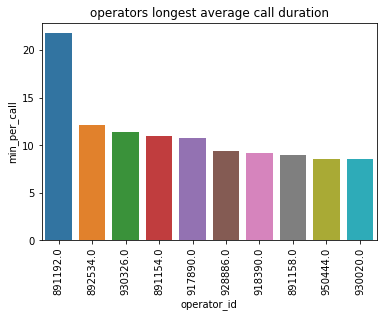

In [56]:
highest_call['operator_id'] = highest_call['operator_id'].astype('str')
sns.barplot(x='operator_id', y='min_per_call', data=highest_call)
plt.title('operators longest average call duration')
plt.xticks(rotation='vertical')
plt.show()

* The chart displays top 10 operators with the longest average call duration.
.

## missed calls : <a class="anchor" id="section_3_2"></a> 

In [57]:
#cheking for error in the data : 
telecom[(telecom['is_missed_call']==True) & (telecom['call_duration']>0)].sort_values(by='call_duration', ascending=False)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
50809,168252,2019-11-25,in,False,940630.0,True,2,741,747,6
50140,168252,2019-10-28,in,False,940658.0,True,3,670,681,11
50433,168252,2019-11-12,in,False,940588.0,True,3,638,651,13
50144,168252,2019-10-28,in,False,940630.0,True,4,636,652,16
50507,168252,2019-11-14,in,False,940588.0,True,4,601,624,23
...,...,...,...,...,...,...,...,...,...,...
37530,167626,2019-10-15,in,False,919206.0,True,1,1,12,11
37310,167626,2019-10-11,in,False,919164.0,True,1,1,10,9
37246,167626,2019-10-10,in,False,919166.0,True,1,1,4,3
36989,167626,2019-10-06,in,False,919204.0,True,1,1,5,4


In [58]:
telecom[(telecom['is_missed_call']==False) & (telecom['call_duration']==0)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
1552,166405,2019-11-16,out,False,902532.0,False,1,0,27,27
2931,166485,2019-09-03,out,True,887276.0,False,1,0,4,4
10254,166678,2019-09-04,out,True,888868.0,False,1,0,5,5
14854,166874,2019-10-05,out,False,893700.0,False,2,0,83,83
21558,167035,2019-10-25,out,False,923528.0,False,1,0,9,9
22568,167061,2019-09-01,out,True,901038.0,False,1,0,7,7
22655,167071,2019-09-24,out,False,913942.0,False,1,0,23,23
27829,167176,2019-10-18,out,True,907964.0,False,1,0,3,3
27943,167176,2019-10-30,out,True,907952.0,False,1,0,2,2
28967,167189,2019-10-06,out,False,906070.0,False,1,0,1,1


* There are missed calls with a duration time above 0 . It isn't make sense. We will not change anything-we will trust this information because maybe it is something to do with a voice mail... 
* There are not misseed calls but with duration of 0 sec. We will not change it too because its only 15 rows.

### total number of missing calls for each operator  <a class="anchor" id="section_3_2_1"></a> 

In [59]:
telecom.query('is_missed_call==True and direction=="in"').shape[0]

684

In [60]:
# number of incoming missing calls by operator
missing_calls_mean = (telecom.query('is_missed_call==True and direction=="in"')
                 .groupby(['operator_id'])['calls_count'].mean().reset_index()
                ) 
missing_calls_mean = missing_calls_mean[missing_calls_mean['calls_count']>0]
missing_calls_mean.columns = ['operator_id', 'avg_calls_missed']

In [61]:
avg_miss = missing_calls_mean.sort_values(by='avg_calls_missed', ascending=False).head(10)
avg_miss

,operator_id,avg_calls_missed
1021,959312.0,7.0
263,905862.0,5.0
504,921814.0,4.0
272,906392.0,3.5
282,906412.0,3.5
722,937956.0,3.0
178,900352.0,3.0
246,905300.0,3.0
242,904344.0,3.0
913,948286.0,3.0


In [62]:
#Average number of all operators
avg_miss.avg_calls_missed.mean()

3.8

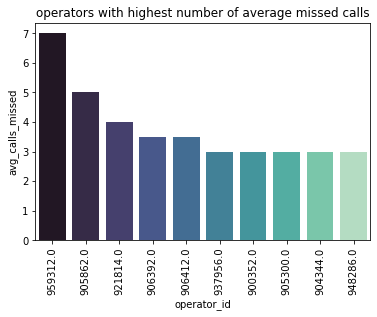

In [63]:
avg_miss['operator_id'] = avg_miss['operator_id'].astype('str')
sns.barplot(x='operator_id', y='avg_calls_missed', palette='mako', data=avg_miss)
plt.title('operators with highest number of average missed calls')
plt.xticks(rotation='vertical')
plt.show()

 most of operators have the average of 3.8 missed calls. It seems that there are not many operators that are above average and we do not see anything out of the ordinary that can be considered inefficient.

In [64]:
avg_miss['operator_id'] = avg_miss['operator_id'].astype('str')

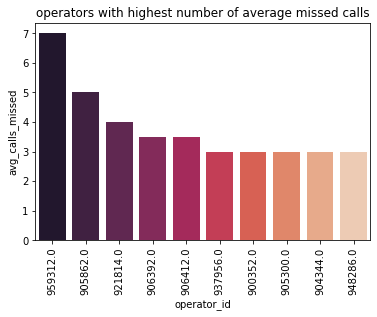

In [65]:
sns.barplot(x='operator_id', y='avg_calls_missed', palette="rocket", data=avg_miss)
plt.title('operators with highest number of average missed calls')
plt.xticks(rotation='vertical')
plt.show()

We will check the partail number of missing calls of all calls by operator to get a more accurate answer

### The partial number of missed calls of total by each operator. <a class="anchor" id="section_3_2_2"></a> 

In [66]:
missing_calls = (telecom.query('is_missed_call==True and direction=="in"')
                 .groupby(['operator_id'])['calls_count'].sum().reset_index()
                ) 
missing_calls.columns = ['operator_id', 'calls_missed']

missing_calls = missing_calls[missing_calls['calls_missed']> 0]

In [67]:
calls_operator = telecom[telecom['direction']=="in"].groupby('operator_id')['calls_count'].sum().reset_index()
calls_operator.columns = ['operator_id', 'calls_total']

In [68]:
calls_part = missing_calls.merge(calls_operator, on='operator_id', how='left')
calls_part.head()

,operator_id,calls_missed,calls_total
0,882680.0,3,99
1,882684.0,4,613
2,882686.0,6,766
3,882690.0,2,171
4,884408.0,4,35


In [69]:
calls_part['missing_from_total'] = calls_part['calls_missed'] / calls_part['calls_total'] * 100
miss_partial = calls_part.sort_values(by='missing_from_total', ascending=False).head(10)  
miss_partial

,operator_id,calls_missed,calls_total,missing_from_total
219,948756.0,1,1,100.000000
58,904344.0,3,4,75.000000
96,913886.0,1,2,50.000000
69,906392.0,7,18,38.888889
34,897872.0,1,3,33.333333
164,937432.0,1,3,33.333333
157,934098.0,2,6,33.333333
228,957922.0,1,3,33.333333
76,906412.0,7,26,26.923077
26,894232.0,1,4,25.000000


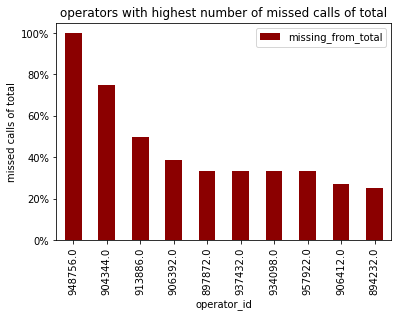

In [70]:
import matplotlib.ticker as mtick
x = (
    miss_partial
    .plot(x="operator_id", y="missing_from_total", 
          kind='bar', color='darkred', title='operators with highest number of missed calls of total')
    
)
plt.ylabel('missed calls of total')
x.yaxis.set_major_formatter(mtick.PercentFormatter())

We will claim that missing_from_total > 30% is bad.

## waiting time : <a class="anchor" id="section_3_3"></a> 

### Average time until answer for incoming calls.  <a class="anchor" id="section_3_3_1"></a> 

In [71]:
#total average
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26


In [72]:
in_calls = telecom[(telecom['direction']=="in") & (telecom['is_missed_call']==False)]

In [73]:
in_calls.describe()

,calls_count,call_duration,total_call_duration,time_wait
count,11994.000000,11994.000000,11994.000000,11994.000000
mean,7.738619,791.570619,892.853093,101.282475
std,15.424210,1509.985037,1625.928519,189.789464
min,1.000000,1.000000,3.000000,0.000000
25%,1.000000,81.000000,108.000000,17.000000
50%,3.000000,295.500000,344.000000,41.000000
75%,8.000000,898.000000,1004.000000,102.000000
max,273.000000,33897.000000,34280.000000,3998.000000


Most of operators answer in average after 1.6 min . After 5 minutes waiting its a lot of time !

In [74]:
# id average time until answer only for incoming calls 
time_to_answer = in_calls.groupby('operator_id')['time_wait'].mean().sort_values(ascending=False).reset_index()
time_to_answer['time_wait_min'] = time_to_answer['time_wait'] / 60
time_to_answer = time_to_answer[time_to_answer['time_wait_min'] > 5]

These are top  aperators with the longest answer time . 

In [75]:
time_to_answer_top =time_to_answer[['operator_id','time_wait_min']]

Text(0, 0.5, 'time wait / min')

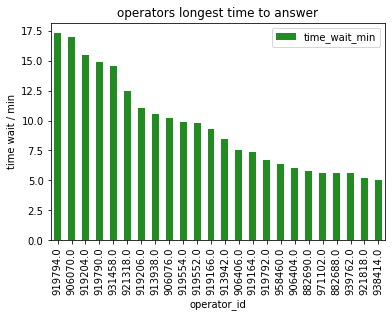

In [76]:
(
    time_to_answer_top
    .plot(x="operator_id", y="time_wait_min", 
          kind='bar', color='forestgreen', title='operators longest time to answer')
    
)
plt.ylabel('time wait / min')

The time until there is an answer could get to 17.5 minutes. Above 5 minutes is long enough.

## Identify inafective operators  <a class="anchor" id="section_3_4"></a> 

We want to cheack is there are operators in more that one 'bad' table . 

In [77]:
time_to_answer_top.head()

,operator_id,time_wait_min
0,919794.0,17.322043
1,906070.0,16.973077
2,919204.0,15.468333
3,919790.0,14.913842
4,931458.0,14.595417


In [78]:
miss_partial.head()

,operator_id,calls_missed,calls_total,missing_from_total
219,948756.0,1,1,100.000000
58,904344.0,3,4,75.000000
96,913886.0,1,2,50.000000
69,906392.0,7,18,38.888889
34,897872.0,1,3,33.333333


In [79]:
highest_call.head()

,operator_id,calls_count,call_duration,min_per_call
0,891192.0,1,1306,21.766667
1,892534.0,5,3645,12.150000
2,930326.0,1,683,11.383333
3,891154.0,371,243908,10.957233
4,917890.0,1,647,10.783333


In [80]:
time_to_answer_top.query('operator_id in @miss_partial.operator_id')

,operator_id,time_wait_min


In [81]:
time_to_answer_top.query('operator_id in @highest_call.operator_id')

,operator_id,time_wait_min


In [82]:
highest_call.query('operator_id in @miss_partial.operator_id')

,operator_id,calls_count,call_duration,min_per_call


In [83]:
a = time_to_answer_top['operator_id']
b= miss_partial['operator_id']
c= highest_call['operator_id']
a

0     919794.0
1     906070.0
2     919204.0
3     919790.0
4     931458.0
5     921318.0
6     919206.0
7     913938.0
8     906076.0
9     919554.0
10    919552.0
11    919166.0
12    913942.0
13    906406.0
14    919164.0
15    919792.0
16    958460.0
17    906404.0
18    882690.0
19    971102.0
20    882688.0
21    939762.0
22    921818.0
23    938414.0
Name: operator_id, dtype: category
Categories (1092, float64): [879896.0, 879898.0, 880020.0, 880022.0, ..., 972412.0, 972460.0, 973120.0, 973286.0]

In [84]:
inefficient_oprator = pd.concat([a,b])

In [85]:
inefficient_oprator = pd.concat([inefficient_oprator,c], ignore_index=True)

In [86]:
inefficient_oprator.head()

0    919794
1    906070
2    919204
3    919790
4    931458
Name: operator_id, dtype: object

* We tried to check if there are operatorss that are in several tables tables and then assume that they are the most ineffective. We did not find any so we added them all to one common table that contains all the operators that were found to be ineffective.
* There are 59 operators that seem to be inefficient enough.

In [87]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26


In [88]:
out = telecom.query('direction=="out" and is_missed_call==False and internal==False')
out.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26
13,166377,2019-08-06,out,False,880020.0,False,5,800,819,19
15,166377,2019-08-07,out,False,880026.0,False,1,21,28,7
16,166377,2019-08-07,out,False,880020.0,False,2,232,240,8
19,166377,2019-08-08,out,False,880022.0,False,2,558,568,10


In [89]:
# the total users for each operator
total_usr = telecom.groupby('operator_id')['user_id'].count().reset_index()
total_usr.columns = ['operator_id', 'total_usr']


In [90]:
# outgoing calls for each operator
partial_usr = out.groupby('operator_id')['user_id'].count().reset_index()
partial_usr.columns = ['operator_id', 'partial_usr']

In [91]:
users_operator = total_usr.merge(partial_usr, on='operator_id')
users_operator

,operator_id,total_usr,partial_usr
0,879896.0,115,44
1,879898.0,224,79
2,880020.0,19,6
3,880022.0,65,33
4,880026.0,173,77
...,...,...,...
1087,972410.0,4,2
1088,972412.0,5,2
1089,972460.0,7,2
1090,973120.0,2,1


In [92]:
# calculating the partiak number of outgoing calls of total to each operator
users_operator['prcnt_effective_calls'] = users_operator['partial_usr'] / users_operator['total_usr'] * 100
users_operator['prcnt_effective_calls'] = users_operator['prcnt_effective_calls']
users_operator.sort_values(by='prcnt_effective_calls')
# excluding velues where total_usr=0
users_operator = users_operator[users_operator['total_usr'] > 0]
#looking values of prcnt_effective_calls under 20%
users_operator[users_operator['prcnt_effective_calls']<20].sort_values(by='prcnt_effective_calls').shape[0]

417

We calculated the number of out going calls of all the calls to each operator. Good operators have high percent of out going calls to its users. There are 417 users which have less than 20% of outgoing calls. We should think what is the percent that is considered inefficient.

# Hypotheses   <a class="anchor" id="chapter4"></a>

## Prepering data and getting more information <a class="anchor" id="section_4_1"></a> 

Our hypotheses test the duration of calls for each tariff. We will merge the data sets together :

In [93]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,time_wait
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26


In [94]:
users.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [95]:
# users and telecom merged data
telecom_tariff = (
    telecom[['user_id', 'operator_id', 'calls_count', 'call_duration', 'time_wait']]
    .merge(users[['user_id', 'tariff_plan']], on='user_id')
)

In [96]:
telecom_tariff.head()

,user_id,operator_id,calls_count,call_duration,time_wait,tariff_plan
0,166377,880022.0,3,0,5,B
1,166377,880020.0,1,0,1,B
2,166377,880020.0,1,10,8,B
3,166377,880022.0,3,0,25,B
4,166377,880020.0,2,3,26,B


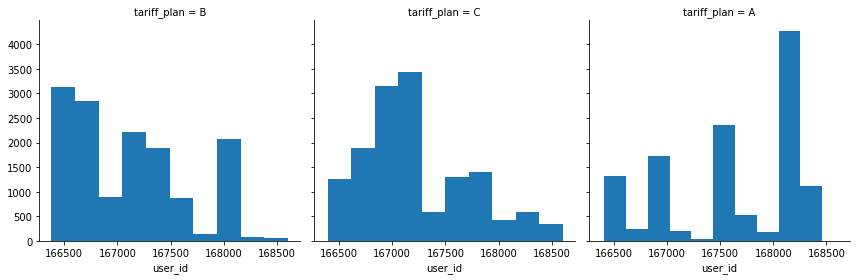

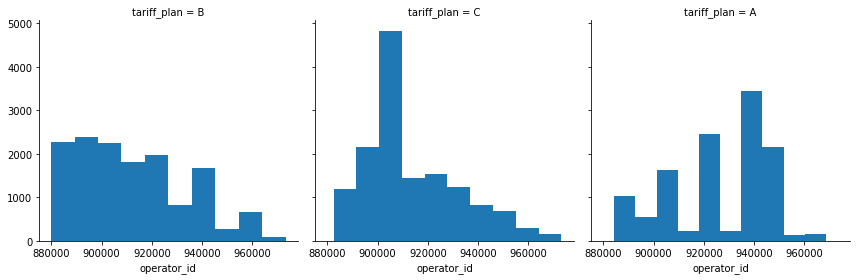

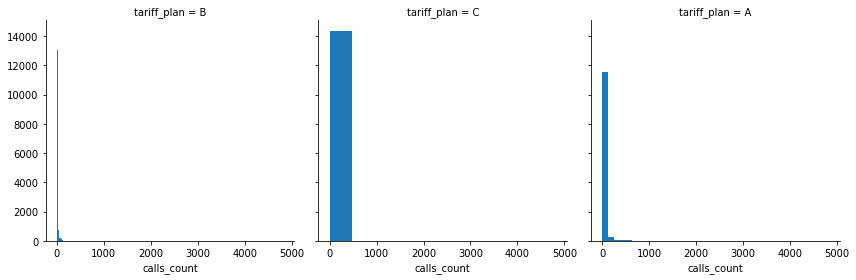

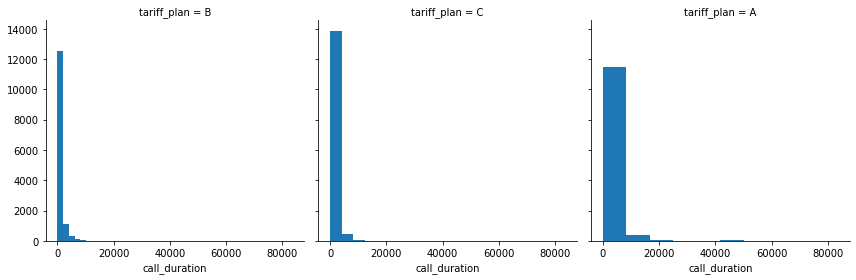

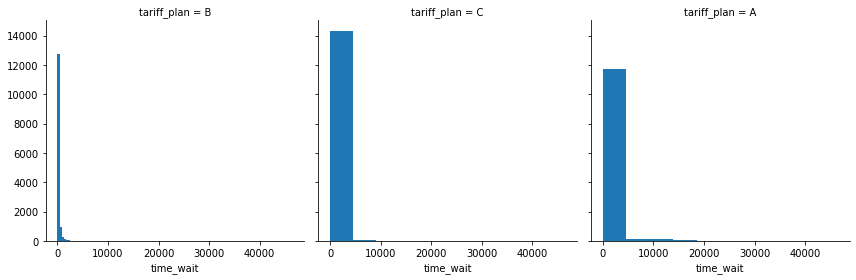

In [97]:
# more information about each column 
for clmn in telecom_tariff[['user_id', 'operator_id', 'calls_count', 'call_duration' ,'time_wait']]:    
    g = sns.FacetGrid(telecom_tariff,col='tariff_plan', height=4)
    g.map(plt.hist, clmn)

The distribution in the duration time column is not normall so we can't use parametric tests .

In [98]:
A = telecom_tariff[telecom_tariff['tariff_plan']=='A']


In [99]:
A.describe()

,user_id,calls_count,call_duration,time_wait
count,11998.000000,11998.000000,11998.000000,11998.000000
mean,167635.399733,29.948491,1572.467995,609.624937
std,625.843547,77.475886,5432.715504,1813.741706
min,166407.000000,1.000000,0.000000,0.000000
25%,166916.000000,2.000000,0.000000,23.000000
50%,167799.000000,6.000000,111.000000,84.000000
75%,168187.000000,27.000000,883.750000,484.000000
max,168459.000000,1248.000000,83560.000000,46474.000000


In [100]:
B = telecom_tariff[telecom_tariff['tariff_plan']=='B']

In [101]:
B.describe()

,user_id,calls_count,call_duration,time_wait
count,14219.000000,14219.000000,14219.000000,14219.000000
mean,167093.148885,9.726915,729.122653,166.190590
std,556.602011,16.918139,1398.001228,302.365314
min,166377.000000,1.000000,0.000000,1.000000
25%,166658.000000,1.000000,0.000000,20.000000
50%,167071.000000,4.000000,118.000000,58.000000
75%,167479.000000,10.000000,812.000000,178.000000
max,168603.000000,267.000000,20223.000000,4171.000000


In [102]:
C = telecom_tariff[telecom_tariff['tariff_plan']=='C']

In [103]:
C.describe()

,user_id,calls_count,call_duration,time_wait
count,14369.000000,14369.000000,14369.000000,14369.000000
mean,167228.453407,12.685991,712.729209,202.006751
std,489.744506,58.407338,1486.932689,765.839212
min,166391.000000,1.000000,0.000000,0.000000
25%,166973.000000,1.000000,0.000000,19.000000
50%,167109.000000,4.000000,120.000000,58.000000
75%,167575.000000,13.000000,744.000000,186.000000
max,168606.000000,4817.000000,41344.000000,45312.000000


Text(0, 0.5, 'count')

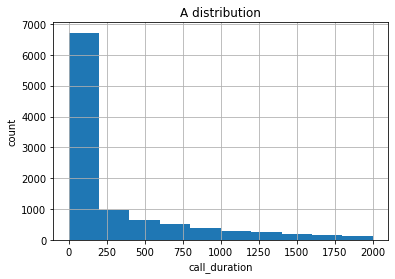

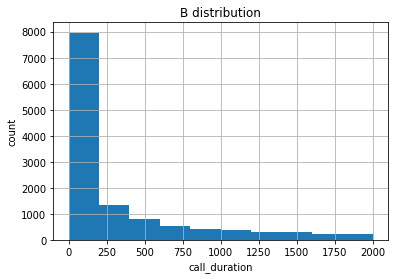

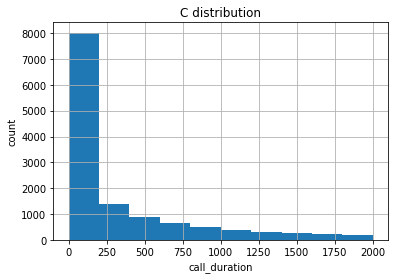

In [104]:

A.hist('call_duration', range=(0,2000))
plt.title('A distribution')
plt.xlabel('call_duration')
plt.ylabel('count')


B.hist('call_duration', range=(0,2000))
plt.title('B distribution')
plt.xlabel('call_duration')
plt.ylabel('count')

C.hist('call_duration', range=(0,2000))
plt.title('C distribution')
plt.xlabel('call_duration')
plt.ylabel('count')

Looks that the three prots are similar. We will make a testing to see a deaper resolution of the differences between tariff groups. 

## Testing hypothesis <a class="anchor" id="section_4_2"></a> 

* Hypothesis : The duration call of each tariff group are significantly different. 
* To check the hypothsis we will use Mann-Whitney test because our data isn't distributed normaly.
* The Mann-Whitney U test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.
 


In [105]:
A_duration = A['call_duration']
B_duration = B['call_duration']
C_duration = C['call_duration']

In [106]:
# Null hypothsis : The groups are equal
# H1 Hypothsis: The groups are not equal.

# Mann-Whitney U test
def MannW(group_1, group_2):
    alpha = .05 #significance level

    results = st.mannwhitneyu(group_1, group_2)

    print('p-value: ', results.pvalue)

    if (results.pvalue < alpha):
        print("Null hypothesis rejected: the difference is statistically significant")
    else:
        print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 

In [107]:
# A compere with B 
MannW(A_duration, B_duration)

p-value:  0.029114022577915122
Null hypothesis rejected: the difference is statistically significant


In [108]:
# A compere with C
MannW(A_duration, C_duration)

p-value:  0.2060251546636619
Failed to reject the null hypothesis: we can't make conclusions about the difference


In [109]:
# B compere with C
MannW(B_duration, C_duration)

p-value:  0.16997576903836886
Failed to reject the null hypothesis: we can't make conclusions about the difference


* Its intresting to see that groups A with C and B with C are consider equal in compere with the groups A with B that is different . 
* The p value of the two lest test are big That even if we raise the alpha the result won't change. 

# Conclusion   <a class="anchor" id="chapter5"></a>

* Our goal in the telecom company focused on the activity of the operators. We examined which operator is less efficient in a number of parameters:largest number of missed calls, longest waiting time for answer, average call duration.
* Call duration - We found that inefficient operators have 10-20 minutes average call duration while the average is 1.7 minutes and therefore we claim that above 8 minutes the call is inefficient.
* missed calls - we calculated the number of missing calls of total calls for each operator. there are operators with 30% and more misiing calls that we claim it is very efficient.
* waiting for answer - The time until there is an answer could get to 17.5 minutes. Above 5 minutes is long enough to be considered ineffective.
* Hypotheses - We claim that the duration call of each tariff group are significantly different:
    To check the hypothsis we used Mann-Whitney test because our data isn't distributed normaly.
    It seems that only groups A and B are not equal . It means that duration call can be considered deifferent between groups .
* We did not find  any operators that belonged to many parameters. This means that each operator has its own weakness that needs to be addressed. 
* Now that we found the inefficient operators, we must examine the causes for inefficiency for most operators, and then act accordingly to improve operator activity.    

# Presentation  <a class="anchor" id="chapter6"></a>

[Telecom presentation](https://drive.google.com/file/d/12KOW4ukZpV-E35gI7YdB0bLchxi4Nivu/view?usp=sharing)

# Dashboard  <a class="anchor" id="chapter7"></a>

[Telecom Dashbord](https://public.tableau.com/authoring/Telecomproject_16103603687870/TelecomProjectdashbord#1)

The size for display is 950X860